# Redshift Catalogs

*Stephen Bailey (Berkeley Lab), Angela Berti (U.Utah), Ragadeepika Pucha (U.Utah), Stephanie Juneau (NOIRLab), Anthony Kremin (Berkeley Lab), Jaime E. Forero-Romero (Uniandes), Farnik Nikakhtar (Yale), Bernardita Ried Guachalla (Stanford), and DESI Data Team*

This tutorial expands on [01_QuickStart.ipynb](01_QuickStart.ipynb) and
[03_DataOrganization.ipynb](03_DataOrganization.ipynb) to cover

  * where the redshift catalogs are and which one to use
  * how to read a subset of columns efficiently
  * how to use `desitarget` to subselect based upon targeting class or other properties
  * why some targets are observed multiple times, and which to use in that case
  * basic quality cuts
  * the difference between target selection and spectral classification

## Imports

In [1]:
import os

import numpy as np
import fitsio
from astropy.table import Table
import matplotlib.pyplot as plt

from desitarget.targetmask import desi_mask

In [2]:
# Determine data location under $DESI_ROOT/spectro/redux/iron
specprod = 'iron'    # Primary spectroscopic production in DR1
desi_root = os.environ['DESI_ROOT']
specprod_dir = f'{desi_root}/spectro/redux/{specprod}'
print(specprod_dir)

/Users/sbailey/desi/tiny_dr1/spectro/redux/iron


In [3]:
# List available redshift catalogs
zcat_dir = f'{specprod_dir}/zcatalog/v1'
os.listdir(zcat_dir)

['zall-pix-iron.fits']

**NOTE**: the environment variable `$DESI_ROOT` indicates the root directory of the DESI data on disk,
equivalent to https://data.desi.lbl.gov/public/dr1

## Which catalog should I use?

There are multiple redshift catalogs, divided into `zpix`, `ztile`, and `zall` files:
  * `ztile-{survey}-{program}-cumulative.fits`: redshifts fit to coadditions of all observations of each target on a given _tile_, but not combining information across tiles.
  * `zpix-{survey}-{program}.fits`: redshifts fit to coadditions of all observations of each target within a given _survey_ and _program_, including combining information across tiles.
  * `zall-pix-{specprod}.fits`: combining all `zpix` catalogs and adding information about which spectra are the best quality when the same target is observed under multiple _survey_ and _program_s.
  * `zall-tilecumulative-{specprod}.fits`: like `zall-pix`, but stacking the `ztile` catalogs.

If you want to work with all spectra taken by DESI, `zall-pix-{specprod}.fits` is the one to use (with e.g. specprod=iron for DR1).
However, if you already know that you want to work with a specific subset of the DESI data, e.g. Emission Line Galaxies (ELGs) observed during the main survey dark program, then you can save yourself time and memory by using the catalog matching just that survey/program, e.g. `zpix-main-dark.fits`.

For the purposes of this tutorial, we'll start with the full `zall-pix-iron.fits` catalog.

## Efficiently reading the catalogs

The redshift catalogs are really big, e.g. in DR1 `zall-pix-iron.fits` is 136 columns by 28 million rows = 21 GB.
In practice it is best to use the `fitsio` library to read just a subset of rows or columns to match what
you really need, rather than reading in the entire table.

Let's start by reading just a few rows to see what all the columns are.  We'll wrap that in an astropy Table
for nicer printing within this tutorial, but the important point is to do the initial reading with fitsio
while subselecting rows or columns.

In [4]:
zcat_file = f'{specprod_dir}/zcatalog/v1/zall-pix-{specprod}.fits'
with fitsio.FITS(zcat_file) as fx:
    zcat = Table(fx['ZCATALOG'][0:10])

In [5]:
print(zcat.colnames)

['TARGETID', 'SURVEY', 'PROGRAM', 'HEALPIX', 'SPGRPVAL', 'Z', 'ZERR', 'ZWARN', 'CHI2', 'COEFF', 'NPIXELS', 'SPECTYPE', 'SUBTYPE', 'NCOEFF', 'DELTACHI2', 'COADD_FIBERSTATUS', 'TARGET_RA', 'TARGET_DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'FA_TARGET', 'FA_TYPE', 'OBJTYPE', 'SUBPRIORITY', 'OBSCONDITIONS', 'RELEASE', 'BRICKNAME', 'BRICKID', 'BRICK_OBJID', 'MORPHTYPE', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'MASKBITS', 'SERSIC', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2', 'REF_ID', 'REF_CAT', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'PARALLAX', 'PHOTSYS', 'PRIORITY_INIT', 'NUMOBS_INIT', 'CMX_TARGET', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SCND_TARGET', 'SV1_DESI_TARGET', 'SV1_BGS_TARGET', 'SV1_MWS_TARGET', 'SV1_SCND_TARGET', 'SV2_DESI_TARGET', 'SV2_BGS_TARGET', 'SV2_MWS_TARGE

That's a lot of columns.  The full datamodel description of each column is given in the
[zall-pix datamodel](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-pix-SPECPROD.html).
Columns include
* `TARGETID`: a unique integer integer identifier for each DESI target, useful for matching to other DESI catalogs
* `TARGET_RA`, `TARGET_DEC`: location on sky in degrees (ICRS reference frame)
* `DESI_TARGET`, `BGS_TARGET`, `MWS_TARGET`, and `SV1_`, `SV2_`, `SV3_` versions of those: target selection mask bits recording why each target was selected for observation.
* `SURVEY` and `PROGRAM`: what survey (e.g. sv1, sv3, main) and sub-survey observing program (e.g. dark, bright) the spectra were observed in.
* Target properties measured from the input DESI Legacy Imaging Surveys, e.g. `FLUX_G/R/Z`, `SHAPE_R/E1/E2`
* Information about the observations: e.g. `MIN/MAX/MEAN_MJD`, `COADD_NUMEXP`
* Classifications `SPECTYPE` and Redshifts `Z` and quality metrics `ZWARN`, `COADD_FIBERSTATUS`, `DELTACHI2`

We'll pick a subset of columns to use in this tutorial.

In [6]:
# Read a selected subset of columns
columns = ['TARGETID', 'SURVEY', 'PROGRAM', 'DESI_TARGET', 'Z', 'SPECTYPE', 'ZWARN', 'DELTACHI2', 'TSNR2_LRG',
           'FLUX_G', 'FLUX_R', 'FLUX_Z', 'ZCAT_PRIMARY', 'ZCAT_NSPEC', 'HEALPIX']

zcatfile = f'{specprod_dir}/zcatalog/v1/zall-pix-{specprod}.fits'
print(f'reading {len(columns)} columns from {os.path.basename(zcatfile)}; this can take 30-60 seconds')

reading 15 columns from zall-pix-iron.fits; this can take 30-60 seconds


In [7]:
zcat = Table(fitsio.read(zcatfile, "ZCATALOG", columns=columns))

Summarizing the columns that we read:
* `TARGETID`: a unique integer for each DESI target
* `SURVEY`: DESI operations are split into different survey phases (e.g. main, sv1, sv3)
* `PROGRAM`: a subdivision of SURVEY, split by observing conditions (e.g. dark, bright)
* `DESI_TARGET`: a bit mask recording why each target was selected for observation
* `Z`: the measured redshift
* `SPECTYPE`: the measured spectral type (e.g. GALAXY, QSO, STAR)
* `ZWARN`: a bit mask flag of redshift/spectype fitting problems; 0 is good
* `DELTACHI2`: the difference in the chi2 of the best fit to the next best fit; bigger is better meaning that the best fit is more confidently the single correct solution
* `TSNR2_LRG`: A signal-to-noise-squared metric, using the as-observed noise of each spectrum but marginalized over the magnitude and redshift distribution of typical DESI LRGs.
* `FLUX_G/R/Z`: object fluxes from imaging (magnitude = 22.5 - 2.5*log10(flux))
* `ZCAT_PRIMARY`: DESI targets can be observed more than once on different tiles / surveys / programs, and thus appear multiple times in a catalog.  This flag indicates which entry is likely the best measurement.
* `ZCAT_NSPEC`: how many spectra have the same `TARGETID` in this catalog.
* `HEALPIX`: which nside=64 nested healpixel this target is on (used for finding the actual spectrum on disk)

## Counting targets by target selection type

In [01_QuickStart.ipynb](01_QuickStart.ipynb), we hardcoded which bits of `DESI_TARGET` correspond to which target types (e.g. MWS, BGS, LRG, ELG, QSO)
based upon the bitmask documenation at https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#target-masks .  We can do this
more algorithmically by using code in `desitarget.targetmask.desi_mask`

In [8]:
desi_tgt = zcat['DESI_TARGET']

is_bgs  = (desi_tgt & desi_mask.BGS_ANY != 0)   #- instead of 2**60
is_lrg  = (desi_tgt & desi_mask.LRG != 0)
is_elg  = (desi_tgt & desi_mask.ELG != 0)
is_qso  = (desi_tgt & desi_mask.QSO != 0)
is_mws  = (desi_tgt & desi_mask.MWS_ANY != 0)
is_scnd = (desi_tgt & desi_mask.SCND_ANY != 0)

# Number of sources of each target type
n_bgs = np.count_nonzero(is_bgs)
n_lrg = np.count_nonzero(is_lrg)
n_elg = np.count_nonzero(is_elg)
n_qso = np.count_nonzero(is_qso)
n_mws = np.count_nonzero(is_mws)
n_scnd = np.count_nonzero(is_scnd)

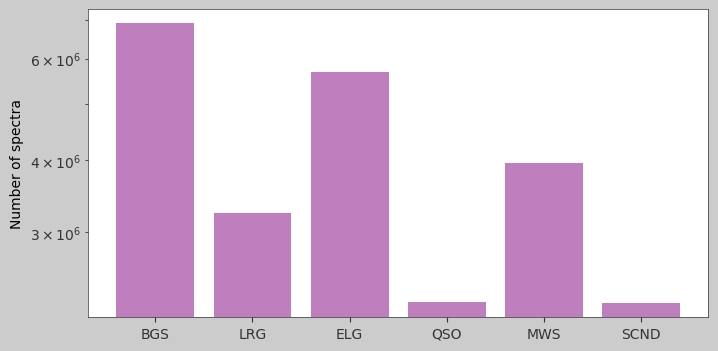

In [9]:
plt.figure(figsize = (8, 4))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of spectra')
plt.yscale('log')

Note that we check `desi_tgt & desi_mask.LRG != 0` instead of `desi_tgt == desi_mask.LRG`.
The former checks that the LRG bit is set, while the latter checks that *only* the LRG bit is set, which
would incorrectly exclude targets that has also passed other selections, e.g. `BGS_ANY`.

The `_ANY` suffix for `BGS_ANY`, `MWS_ANY`, and `SCND_ANY` refers to the fact that these selections
have many sub-bits differentiating different types of BGS/MWS/Secondaries.  These are kept in
additional columns `BGS_TARGET`, `MWS_TARGET`, `SCND_TARGET`.  e.g. if the `desi_mask.BGS_ANY` bit
is set, that means that additional bits are set in the `BGS_TARGET` column, which can be used
to determine which BGS sub-selection applies to this target.

We can also use `desi_mask` to construct multi-bit masks, e.g.

In [10]:
#- equivalent to comparing with desi_mask.BGS_ANY | desi_mask.LRG | desi_mask.ELG
is_galaxy_target = desi_tgt & desi_mask.mask('BGS_ANY|LRG|ELG') != 0
num_galaxy_target = np.sum(is_galaxy_target)
print(f'DR1 includes {num_galaxy_target:,} galaxy targets')

DR1 includes 15,077,426 galaxy targets


Printing `desi_mask` lists all `DESI_TARGET` bits that are defined, including a brief description and the observing conditions under which that bit is designed to be observed.  This same information is availabel at https://github.com/desihub/desitarget/blob/2.5.0/py/desitarget/data/targetmask.yaml.

In [12]:
print(desi_mask)

desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3000, 'MORE_ZGOOD': 2, 'MORE_ZWARN': 2, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0}, 'numobs': 2}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3350, 'MORE_ZWARN': 3300, 'MORE_MIDZQSO': 100, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 4}]
  - [QSO_HIZ,          4, "QSO selected using high-redshift Random Forest (informational bit)", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 0, 'DONE': 0, 'OBS': 0, 'DONOTOBSERVE': 0, 'MORE_MIDZQSO': 0, 'MORE_ZWARN': 0, 'MORE_ZGOOD': 0}, 'numobs': -1}]
  - [ELG_LOP,          5, "ELG at standard (ELG) priority", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3100, 'MORE_ZGOOD': 2,

### Important Detail: `*_TARGET` columns are only set per-SURVEY

It is important to note that the targeting mask bits `DESI_TARGET`, `BGS_TARGET`, `MWS_TARGET`, and `SCND_TARGET` (secondary targets)
are only set for observations during the DESI Main Survey, i.e. `SURVEY=="main"`.  They are *not* set for targets observed under other
surveys, even if the targets for those surveys would have passed the DESI Main Survey target selection cuts.

Each of the other Survey Validation surveys (sv1, sv2, sv3) have their own bitmask columns, e.g. `SV1_DESI_TARGET` and `SV3_BGS_TARGET`.
The equivalent to `desitarget.targetmask.desi_mask` for sv1 is `desitarget.sv1.sv1_targetmask.desi_mask`, and similarly for sv2 and sv3.
Like the Main Survey targeting columns, these are *not* set for targets observed under other surveys.

### Multiple observations of the same target

The same target can be observed multiple times in DESI.  These are processed independently, resulting in multiple
redshift entries for the same `TARGETID` in the catalogs. While this is somewhat inefficient for observing, it
allows the various programs of DESI to be analyzed independently without the target selection and observation
choices from one program impacting the uniformity and quality of the data from another program.

When a target is included in the catalog multiple times, the column `ZCAT_PRIMARY` indicates
which observation is recommended as the best observation.

Let's remake the bar chart of number of spectra per target class, also indicating the number of
unique spectra by filtering on `ZCAT_PRIMARY==True`

In [13]:
is_primary = zcat["ZCAT_PRIMARY"]

n_bgs_prim  = np.count_nonzero(is_bgs & is_primary)
n_lrg_prim  = np.count_nonzero(is_lrg & is_primary)
n_elg_prim  = np.count_nonzero(is_elg & is_primary)
n_qso_prim  = np.count_nonzero(is_qso & is_primary)
n_mws_prim  = np.count_nonzero(is_mws & is_primary)
n_scnd_prim = np.count_nonzero(is_scnd & is_primary)

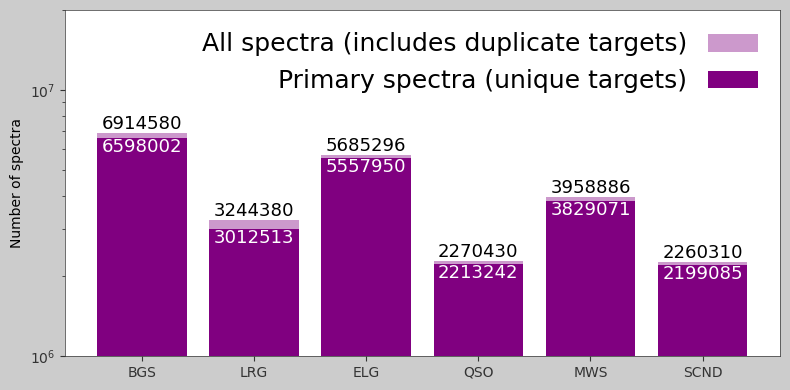

In [14]:
plt.figure(figsize = (8, 4))

targets = ["BGS", "LRG", "ELG", "QSO", "MWS", "SCND"]
counts = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]
counts_prim = [n_bgs_prim, n_lrg_prim, n_elg_prim, n_qso_prim, n_mws_prim, n_scnd_prim]

plt.bar(targets, counts, color="purple", alpha=0.4, label="All spectra (includes duplicate targets)")
plt.bar(targets, counts_prim, color="purple", alpha=1, label="Primary spectra (unique targets)")
plt.ylabel("Number of spectra")
plt.semilogy()
plt.ylim(1e6, 2e7)

for i in range(len(targets)):
    plt.text(targets[i], counts[i], counts[i], ha="center", va="bottom", fontsize=13)
    plt.text(targets[i], counts_prim[i], counts_prim[i], ha="center", va="top", fontsize=13, color="white")

plt.legend(fontsize=18, frameon=False, markerfirst=False)
plt.tight_layout()
plt.show()

Let's explore some example repeats in more detail.

First of all, how many targets have repeat observations, and how many repeats?

In [15]:
unique_targetids, unique_counts = np.unique(zcat['TARGETID'], return_counts=True)

Text(0.5, 0, 'Number of entries per TARGETID')

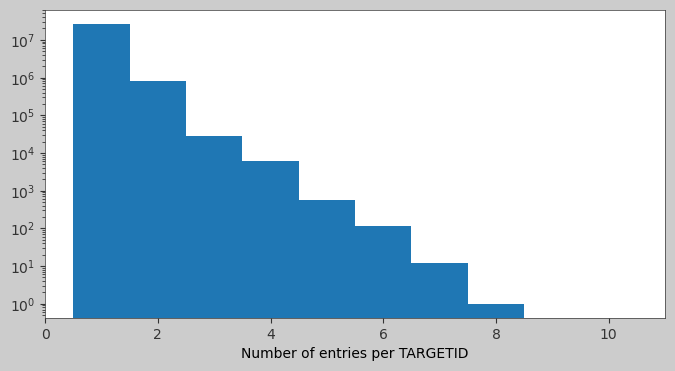

In [16]:
plt.figure(figsize=(8,4))
plt.hist(unique_counts, bins=10, range=(0.5, 10.5), log=True,)
plt.xlabel('Number of entries per TARGETID')

Most targets are observed only once, there are nearly a million observed twice,
and a handful of targets observed up to 8 times.

In [17]:
num_unique_targetids = len(unique_targetids)
num_zcat_primary = np.sum(zcat['ZCAT_PRIMARY'])
print(f'{num_unique_targetids} should match {num_zcat_primary} targets with ZCAT_PRIMARY==True')

27547223 should match 27547223 targets with ZCAT_PRIMARY==True


Let's explore some cases in detail.

In [18]:
# All targets with 3 entries each in the redshift catalog
ii = (unique_counts == 3)
targets_3x = unique_targetids[ii]
x3 = np.isin(zcat['TARGETID'], targets_3x)

In [19]:
# Details about the first one
jj = (zcat['TARGETID'] == zcat['TARGETID'][x3][0])
zcat['TARGETID', 'SURVEY', 'PROGRAM', 'DESI_TARGET'][jj]

TARGETID,SURVEY,PROGRAM,DESI_TARGET
int64,str7,str6,int64
39628478462558938,cmx,other,0
39628478462558938,main,bright,1152921504606912513
39628478462558938,main,dark,1152921504606912513


This target was observed during DESI commissioning (SURVEY=cmx) and also during the main survey
under both dark and bright conditions.  To understand why, we can parse the
`DESI_TARGET` values using `desitarget.targetmask.desi_mask.names` to convert a bit mask into the list of bit names that are set:

In [20]:
this_desi_tgt = zcat['DESI_TARGET'][jj][-1]
print(f'DESI_TARGET={this_desi_tgt} is')
print(desi_mask.names(this_desi_tgt))

DESI_TARGET=1152921504606912513 is
['LRG', 'LRG_SOUTH', 'BGS_ANY']


This was targeted as both a Luminous Red Galaxy (LRG) to be observed under dark conditions,
and also a Bright Galaxy Survey (BGS) galaxy to be observed under bright conditions.

**Detail**: The `LRG_SOUTH` bit is a subset of LRGs, indicating that it was selected from imaging taken with DECam, as opposed to `LRG_NORTH` targets selected with imaging taken with BASS and MzLS.

**Detail**: The main survey DESI target selection had not yet been finalized during DESI commisioning, thus `DESI_TARGET` was not set for that observation.  Another column that we didn't read, `CMX_TARGET`, would have had the targeting information for that observation,
and could be interpreted using `desitarget.cmx.cmx_targetmask.cmx_mask`.

### Targets observed multiple times under different PROGRAMs of the same SURVEY

This situation of targets passing both LRG and BGS cuts is one of the most common reasons why
a target would be observed multiple times under different programs (observing conditions) even
for the same survey. Let's count those.

In [21]:
# both bits are set
both_bgs_lrg = desi_tgt & desi_mask.mask('LRG|BGS_ANY') == desi_mask.mask('LRG|BGS_ANY')
n_both_bgs_lrg = np.sum(both_bgs_lrg)

print(f'{n_both_bgs_lrg}/{n_bgs} ({100*n_both_bgs_lrg/n_bgs:.1f}%) of BGS targets are also LRG targets')
print(f'{n_both_bgs_lrg}/{n_lrg} ({100*n_both_bgs_lrg/n_lrg:.1f}%) of LRG targets are also BGS targets')

748759/6914580 (10.8%) of BGS targets are also LRG targets
748759/3244380 (23.1%) of LRG targets are also BGS targets


### Targets observed under multiple SURVEYs

Another common reason for catalog repeats is Survey Validation (SV) targets re-observed
during the main survey.

In [22]:
is_sv = (zcat['SURVEY'] == 'sv1') | (zcat['SURVEY'] == 'sv2') | (zcat['SURVEY'] == 'sv3')
is_main = (zcat['SURVEY'] == 'main')

sv_main_targetids = np.intersect1d(zcat['TARGETID'][is_sv], zcat['TARGETID'][is_main])
num_sv_main = len(sv_main_targetids)
print(f'{num_sv_main} targets were observed in both SV and the main survey (as of DR1)')

475305 targets were observed in both SV and the main survey (as of DR1)


Let's explore a few of those cases

In [23]:
ii = zcat['TARGETID'] == sv_main_targetids[0]
zcat['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZWARN', 'TSNR2_LRG', 'ZCAT_PRIMARY'][ii]

TARGETID,SURVEY,PROGRAM,Z,ZWARN,TSNR2_LRG,ZCAT_PRIMARY
int64,str7,str6,float64,int64,float32,bool
39627580520799058,main,bright,0.28995979459690663,0,26.199902,True
39627580520799058,sv1,bright,0.932752477574551,518,229.25911,False


That target was observed under both sv1/bright and main/bright, and has a much higher
TSNR2_LRG value for sv1/bright, but it also has a ZWARN flag indicating some problem
with the measured redshift, thus the main/bright version was selected as `ZCAT_PRIMARY`.

In [24]:
ii = zcat['TARGETID'] == sv_main_targetids[1]
zcat['TARGETID', 'SURVEY', 'PROGRAM', 'Z', 'ZWARN', 'TSNR2_LRG', 'ZCAT_PRIMARY'][ii]

TARGETID,SURVEY,PROGRAM,Z,ZWARN,TSNR2_LRG,ZCAT_PRIMARY
int64,str7,str6,float64,int64,float32,bool
39627580524986917,main,bright,0.44556880037340607,0,24.427383,False
39627580524986917,sv1,bright,0.4457768361222392,0,45.870617,True


This target was also observed under both main/bright and sv1/bright, but in this case the
sv1/bright observation had higher `TSNR2_LRG` and no `ZWARN` flag and thus was selected as the best.

**NOTE**: Even though DR1 is focused on new data from the DESI main survey, the Survey Validation (sv1, sv2, sv3)
data are still included because sometimes they have higher S/N data than the main survey observations.

**NOTE**: if your primary goal is to find the highest S/N successful fit of a given target,
then `ZCAT_PRIMARY` is a good filter.  However, this decreases the uniformity of the sample,
e.g. by bringing in extra deep sv1 observations or higher S/N dark-time observations of otherwise
bright-time targets.  If uniformity is a higher priority (e.g. for large scale structure analyses),
then using the individual `zpix-{survey}-{program}.fits` catalogs is better.

## Quality cuts

The redshift catalogs include all targets observed by DESI, even if they have poor data or failed redshift fits.
Note that `ZCAT_PRIMARY` indicates the best observation of each target, but that doesn't guarantee that the best observation was
actually a good observation.  We recommend the following set of cuts as a starting point:

* `ZCAT_PRIMARY == True`, or using individual `zpix-{survey}-{program}.fits` catalogs to get unique entries
* `ZWARN == 0` to eliminate known redshift fitting failures and hardware problems
* `DELTACHI2 > 25`: this variable records the chi2-difference between the best redshift fit and the next best solution.  Higher values indicate more confidence that the given `Z` and `SPECTYPE` are uniquely the best.  Increasing the `DELTACHI2` cut will improve purity at the expense of completeness.  The best choice is an analysis dependent quantity, but 25 is a reasonable starting point.

**Detail**: `COADD_FIBERSTATUS` is a bitmask indicating known hardware problems, irrespective of whether the redshift fit
succeeded or not.  Some analyses want to eliminate known hardware problems (`COADD_FIBERSTATUS==0`) while being independent
of whether the Redrock redshift fit succeeded (`ZWARN==0`) or not.

## Target type vs. classified spectral type

`DESI_TARGET` records why a target was observed, e.g. because target selection thought it was an
LRG, ELG, or QSO, but that doesn't guarantee that it actually was an LRG, ELG, or QSO.
The result of the [Redrock](https://github.com/desihub/redrock)
fit to the as-observed spectrum is contained in the `SPECTYPE` and `Z` columns.

Let's explore this for QSO targets, while filtering to good quality fits and their `SPECTYPE`.

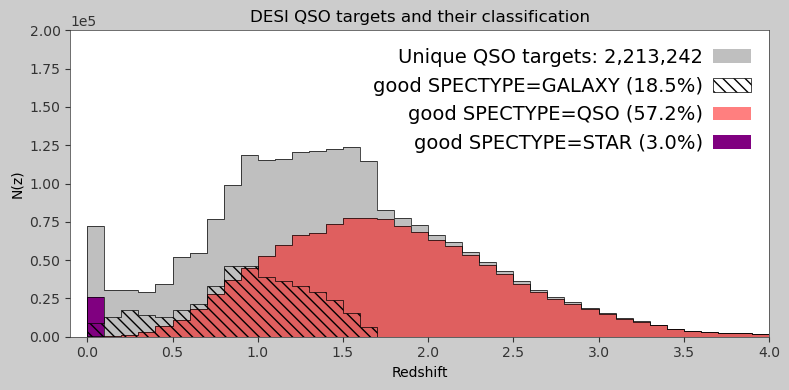

In [25]:
is_good = (zcat['ZWARN']==0) & (zcat['DELTACHI2']>25)

fig, ax = plt.subplots(1, 1, figsize=(8,4))

bins = np.arange(0,4.1,0.1)

#-- all QSO targets
ax.hist(zcat["Z"][is_qso & is_primary], bins=bins, color="gray", alpha=0.5, label=f"Unique QSO targets: {n_qso_prim:,}")

#-- QSO targets classified as galaxies
spec_gal = is_qso & is_primary & (zcat["SPECTYPE"]=="GALAXY") & is_good
ax.hist(zcat["Z"][spec_gal], bins=bins, histtype="step", hatch="\\\\\\", color="k", lw=1.5,
        label=f"good SPECTYPE=GALAXY ({100*np.sum(spec_gal)/n_qso:.1f}%)")

#-- QSO targets classified as quasars
spec_qso = is_qso & is_primary & (zcat["SPECTYPE"]=="QSO") & is_good
ax.hist(zcat["Z"][spec_qso], bins=bins, color="red", alpha=0.5,
        label=f"good SPECTYPE=QSO ({100*np.sum(spec_qso)/n_qso:.1f}%)")
ax.hist(zcat["Z"][spec_qso], bins=bins, histtype="step", color="k", lw=1)

#-- QSO targets classified as stars
spec_star = is_qso & is_primary & (zcat["SPECTYPE"]=="STAR") & is_good
ax.hist(zcat["Z"][spec_star], bins=bins, color="purple",
        label=f"good SPECTYPE=STAR ({100*np.sum(spec_star)/n_qso:.1f}%)")
ax.hist(zcat["Z"][spec_star], bins=bins, histtype="step", color="k", lw=1)

ax.hist(zcat["Z"][is_qso & is_primary], bins=bins, histtype="step", color="black", lw=2)

ax.legend(fontsize=14, markerfirst=False, handletextpad=0.5, frameon=False)

ax.set_xlabel("Redshift")
ax.set_xlim(-0.1,4.0)
ax.set_ylim(0, 2e5)
ax.set_xticks(np.arange(0,4.1,0.5))
ax.set_ylabel("N(z)")
ax.set_title('DESI QSO targets and their classification')
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))

plt.tight_layout()

**Exercise**: why don't the good SPECTYPE=GALAXY/QSO/STAR percentages add up to 100%?

**Note**: ~20% of QSO targets are classified as galaxies or stars.
Some of these are genuinely galaxies or stars instead of quasars,
but they also include cases of AGN-like galaxies which have both galaxy-like and QSO-like properties.
In the end, `SPECTYPE` records what Redrock template set had the best fit to the data;
it isn't intended for detailed physics statements differentiating ambiguous cases of galaxies vs. quasars.

## Summary

* DR1 redshift catalogs are under `spectro/redux/iron/zcatalog/v1/`
  * Use `zall-pix-iron.fits` if you are looking for all observations from DESI.
  * Use `zpix-{survey}-{program}.fits` if you know you are interested in the targets from a particular subset of DESI DR1, e.g. ELG or LRG targets observed during survey=main program=dark.
  * `ztile*.fits` and `zall-tilecumulative-iron.fits` are for more specialized analyses.
* Use `fitsio.read(filename, 'CATALOG', columns=...)` to read just the subset of columns that you need.  Otherwise you will need a large amount of memory and patience to read the entire catalog.
* `desitarget.target_mask.desi_mask` provides utilities for parsing the `DESI_TARGET` column bitmask without hardcoding magic numbers copied from documentation.
* Targets can be observed multiple times and processed independently, resulting in multiple entries per `TARGETID`.
  * Use `ZCAT_PRIMARY==True` to get the recommended single-best observation.  If there is only one observation, it will have `ZCAT_PRIMARY==True`.
* Also use `ZWARN==0` and `DELTACHI2>25` as a starting point for additional quality cuts.
* `DESI_TARGET` indicates why a target was observed; `SPECTYPE` and `Z` indicate the results of fitting the spectra.